In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training set shape: (30, 2500), (30,)
Testing set shape: (20, 2500), (20,)
PCA with 10 components


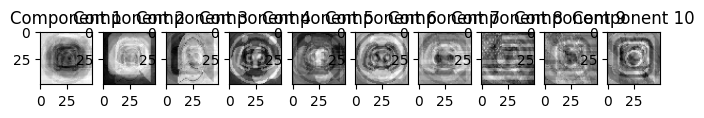

LDA with 9 components


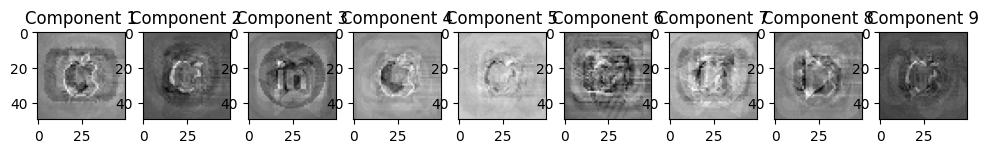

PCA Results:
Components: 10, Accuracy: 0.0500, Precision: 0.0143, Recall: 0.0500, F1 Score: 0.0222

LDA Results:
Components: 9, Accuracy: 0.0500, Precision: 0.0111, Recall: 0.0500, F1 Score: 0.0182

Comparison of PCA and LDA:
PCA with 10 components -> Accuracy: 0.0500, Precision: 0.0143, Recall: 0.0500, F1 Score: 0.0222
LDA with 9 components -> Accuracy: 0.0500, Precision: 0.0111, Recall: 0.0500, F1 Score: 0.0182


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Path to the dataset
data_path = '/content/drive/MyDrive/Dataset'

# Function to read images from a directory
def read_images_from_dir(directory):
    imgs = []
    for file in sorted(os.listdir(directory)):
        image_path = os.path.join(directory, file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (50, 50))  # Standardize image size to 50x50
            imgs.append(img)
    return imgs

# Load dataset
data = []
labels = []
class_names = sorted(os.listdir(data_path))
for label_index, label_name in enumerate(class_names):
    class_dir = os.path.join(data_path, label_name)
    images = read_images_from_dir(class_dir)
    data.extend(images)
    labels.extend([label_index] * len(images))  # Assign numeric labels

data = np.array(data)
labels = np.array(labels)

# Normalize images
data = data / 255.0

# Reshape images to (num_samples, num_features)
data = data.reshape(data.shape[0], -1)

# Split the dataset into training and testing sets
train_data, train_labels, test_data, test_labels = [], [], [], []

train_size = 3  # First 3 images for training
test_size = 2   # Next 2 images for testing

for label_index in range(len(class_names)):
    class_indices = np.where(labels == label_index)[0]
    train_data.extend(data[class_indices[:train_size]])
    train_labels.extend(labels[class_indices[:train_size]])
    test_data.extend(data[class_indices[train_size:train_size + test_size]])
    test_labels.extend(labels[class_indices[train_size:train_size + test_size]])

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Print shapes
print(f"Training set shape: {train_data.shape}, {train_labels.shape}")
print(f"Testing set shape: {test_data.shape}, {test_labels.shape}")

# Implement PCA
def perform_pca(components, train_data, test_data):
    pca_model = PCA(n_components=components)
    train_data_pca = pca_model.fit_transform(train_data)
    test_data_pca = pca_model.transform(test_data)
    return train_data_pca, test_data_pca, pca_model

# Implement LDA
def perform_lda(components, train_data, train_labels, test_data):
    lda_model = LDA(n_components=components)
    train_data_lda = lda_model.fit_transform(train_data, train_labels)
    test_data_lda = lda_model.transform(test_data)
    return train_data_lda, test_data_lda, lda_model

# Analyze the effect of varying the number of principal components
pca_components_list = [10]  # Limited to 10 due to having only 10 classes
for components in pca_components_list:
    train_data_pca, test_data_pca, pca_model = perform_pca(components, train_data, test_data)
    print(f"PCA with {components} components")

    # Visualize the first n components
    plt.figure(figsize=(8, 4))
    for i in range(1, components + 1):
        plt.subplot(1, components, i)
        plt.imshow(pca_model.components_[i-1].reshape(50, 50), cmap='gray')
        plt.title(f'Component {i}')
    plt.show()

# Analyze the effect of varying the number of discriminant features
lda_components_list = [9]  # Maximum is 9 because of 10 classes (n_classes - 1)
for components in lda_components_list:
    train_data_lda, test_data_lda, lda_model = perform_lda(components, train_data, train_labels, test_data)
    print(f"LDA with {components} components")

    # Visualize the first n discriminant features
    plt.figure(figsize=(12, 4))
    for i in range(components):
        plt.subplot(1, components, i + 1)
        plt.imshow(lda_model.scalings_[:, i].reshape(50, 50), cmap='gray')
        plt.title(f'Component {i+1}')
    plt.show()

# Build and evaluate the Template Matching system using KNN
def evaluate_model(train_data, train_labels, test_data, test_labels):
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(train_data, train_labels)
    predictions = model.predict(test_data)

    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(test_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(test_labels, predictions, average='macro', zero_division=0)

    return accuracy, precision, recall, f1

# Evaluation for PCA
results_pca = {}
for components in pca_components_list:
    train_data_pca, test_data_pca, _ = perform_pca(components, train_data, test_data)
    accuracy, precision, recall, f1 = evaluate_model(train_data_pca, train_labels, test_data_pca, test_labels)
    results_pca[components] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Evaluation for LDA
results_lda = {}
for components in lda_components_list:
    train_data_lda, test_data_lda, _ = perform_lda(components, train_data, train_labels, test_data)
    accuracy, precision, recall, f1 = evaluate_model(train_data_lda, train_labels, test_data_lda, test_labels)
    results_lda[components] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

# Display results
print("PCA Results:")
for components, metrics in results_pca.items():
    print(f"Components: {components}, Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1']:.4f}")

print("\nLDA Results:")
for components, metrics in results_lda.items():
    print(f"Components: {components}, Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1']:.4f}")

# Compare the performance of PCA and LDA
print("\nComparison of PCA and LDA:")
for components in pca_components_list:
    pca_metrics = results_pca[components]
    print(f"PCA with {components} components -> Accuracy: {pca_metrics['accuracy']:.4f}, Precision: {pca_metrics['precision']:.4f}, Recall: {pca_metrics['recall']:.4f}, F1 Score: {pca_metrics['f1']:.4f}")

for components in lda_components_list:
    lda_metrics = results_lda[components]
    print(f"LDA with {components} components -> Accuracy: {lda_metrics['accuracy']:.4f}, Precision: {lda_metrics['precision']:.4f}, Recall: {lda_metrics['recall']:.4f}, F1 Score: {lda_metrics['f1']:.4f}")
